# Sea ice comparisons: Observations vs Earth System Models
In this notebook, we will compare the ability of GFDL-MOM6-COBALT2 (current environmental forcing used by FishMIP models) and 11 CMIP6 models (see [Rohr et al 2023](https://doi.org/10.1038/s43247-023-00871-w)) to reproduce past sea ice conditions in the Southern Ocean (south of $30^{\circ}$S). The temporal range of these three data sources does not match, so we are comparing climatoligcal means for a period that is common to all: November 1978 to December 2010. Given the high seasonality of the Southern Ocean, we will compare climatologies for two seasons: summer (December to February) and winter (June to August).  
  
Observations come from [NOAA/NSIDC Climate Data Record of Passive Microwave Sea Ice Concentration, Version 4](https://nsidc.org/data/g02202/versions/4), which are available in Gadi. This dataset uses a threshold of 10\% to define ice covered ocean, which means that any ocean areas with sea ice coverage lower than this threshold are classified as "ice free" areas. Earth System Models do not have such a threshold, so we will be applying it to ensure consistency across datasets.  

Sea ice data from CMIP6 models are also available in Gadi. The GFDL-MOM6-COBALT2 data used in this comparison is not in its native grid, instead it was regridded by the ISIMIP team, and it is available from the DKRZ server and the [ISIMIP data portal](https://data.isimip.org/).

## Loading relevant libraries

In [1]:
#Packages for file management
import os
from glob import glob

#Data wrangling
import pandas as pd
import numpy as np
import datetime as dt
import xarray as xr
from itertools import cycle
import string
from scipy.io import loadmat
import re

#Package to access ACCESS-OM2-01 outputs
# import cosima_cookbook as cc

#Packages for plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
import matplotlib.gridspec as gridspec
import geopandas as gp

## Setting working directory

In [2]:
os.chdir('/g/data/jk72/la6889/FishMIP/SOMEME/')

## Loading sea ice concentration (SIC) data from observations
GADI has SIC data for the northern and southern hemisphere at daily and monthly temporal resolutions. For this comparison, we will use monthly data for the southern hemisphere as our focus is the Southern Ocean.

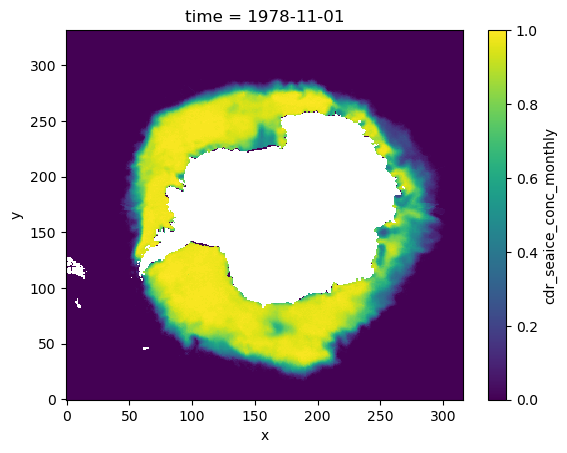

In [3]:
#File containing all SIC data - Adding search term for monthly and Southern Ocean data ("monthly_sh")
base_sic_path = '/g/data/hh5/tmp/cosima/observations/NOAA/G02202_V4/*monthly_sh_197811_202212*.nc'

#Get a list of paths with all available data
[monthly_sic_path] = glob(base_sic_path)
#Loading dataset
nsidc_ds = xr.open_dataset(monthly_sic_path, decode_times = False, autoclose = True)['cdr_seaice_conc_monthly']

#Getting time units to decode time correctly
time_units = nsidc_ds.time.units
#Decode time
decoded_time = xr.conventions.times.decode_cf_datetime(nsidc_ds.time, time_units)
#Rename time dimension
nsidc_ds = nsidc_ds.rename({'tdim': 'time'})
#Add decoded time to dataset
nsidc_ds['time'] = ('time', decoded_time, {'long_name': 'time', 'decoded_using': time_units})

#Subset dataset for period of interest
nsidc_ds = nsidc_ds.sel(time = slice('1978', '2010'))

#Change flag values (any pixels with values anbove 1) to NAs
nsidc_ds = xr.where(nsidc_ds > 1, np.nan, nsidc_ds)

#Checking first time step
nsidc_ds.isel(time = 0).plot()

## Calculating seasonal climatologies
To perform comparisons between the observations and Earth System Models, we will calculate a climatological mean per season.

In [4]:
#Change grid cells with values less than 0.1 to NAs and change to percentage
nsidc_clim = xr.where(nsidc_ds < 0.1, np.nan, nsidc_ds).groupby('time.season').mean()*100

## Loading sea ice data from GFDL-MOM6-COBALT2
Data from this model was regridded by ISIMIP and it was obtained from DKRZ. This is a global model, but we will only consider data for the Southern Ocean.

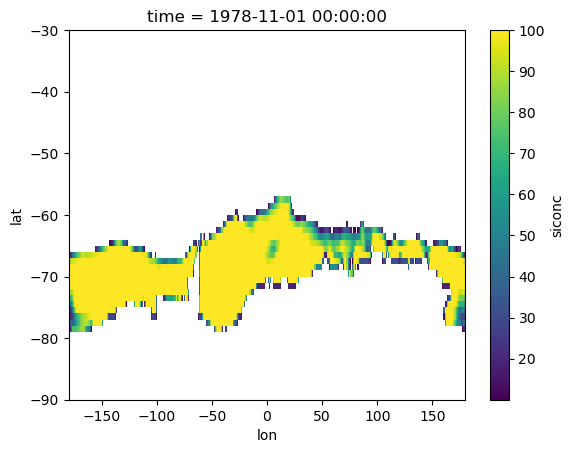

In [5]:
#Load GFDL data
gfdl_sic = xr.open_dataarray('data/gfdl-mom6-cobalt2_obsclim_siconc_60arcmin_global_monthly_1961_2010.nc')
#Select area and period of interest
gfdl_sic = gfdl_sic.sel(lat = slice(-30, -90), time = slice('1978-11', '2010'))
#Apply 10% SIC threshold to match observations
gfdl_sic = xr.where(gfdl_sic < 10, np.nan, gfdl_sic)
#Check first time step
gfdl_sic.isel(time = 0).plot()

## Calculating seasonal climatologies

In [6]:
gfdl_clim = gfdl_sic.groupby('time.season').mean()

## Loading sea ice data from CMIP6 models
We will be including 11 models in our comparisons. We used [Rohr et al 2023](https://doi.org/10.1038/s43247-023-00871-w) as a reference point for our choice of CMIP6 models to be included in this comparison.

In [116]:
#Getting list of all models available in folder
# cmip_files = glob('/g/data/jk72/tr0445/CMIP6_Hist_KM/*')

# #Empty dictionary to store CMIP6 data
# cmip_ds = {}

#Loop through each file
for f in cmip_files[7:]:
    #Extracting model name from file name
    [mod_name] = re.findall('(.*)_.*', os.path.basename(f))
    #Loading data
    ds_mat = loadmat(f)
    #Getting longitude
    lon = ds_mat['Lon'][0]
    #Changing longitude range to +/-180
    lon = ((lon+180)%360)-180
    #Getting longitude and latitude
    lat = ds_mat['Lat'][:,0]
    #Creating data array
    sic_ds = xr.DataArray(data = ds_mat['siconc'],
                          dims = ['time', 'lat', 'lon'],
                          coords = {'lat': lat, 'lon': lon, 
                                    #Monthly data
                                    'time': range(1, 13)})
    #Rearrange data by longitudes
    sic_ds = sic_ds.sortby(sic_ds.lon)
    #Mask flag values and subset data for the Southern Ocean
    sic_ds = xr.where(sic_ds >= 1e20, np.nan, sic_ds).sel(lat = slice(-90, -30))
    #Add dataset to dictionary
    if sic_ds.max() > 1:
        cmip_ds[mod_name] = sic_ds
    else:
        #If maximum values is greater than 1, then multiply by 100
        cmip_ds[mod_name] = sic_ds*100

In [74]:
cmip_files
# xr.where(sic_ds >= 1e20, np.nan, sic_ds)
#Mask values below 10%
    # sic_ds = xr.where(sic_ds < 10, np.nan, sic_ds)

['/g/data/jk72/tr0445/CMIP6_Hist_KM/CESM2_Clims.mat',
 '/g/data/jk72/tr0445/CMIP6_Hist_KM/CanESM5-CMOC_Clims.mat',
 '/g/data/jk72/tr0445/CMIP6_Hist_KM/IPSL-CM6A-LR_Clims.mat',
 '/g/data/jk72/tr0445/CMIP6_Hist_KM/CMCC-ESM2_Clims.mat',
 '/g/data/jk72/tr0445/CMIP6_Hist_KM/CNRM-ESM2-1_Clims.mat',
 '/g/data/jk72/tr0445/CMIP6_Hist_KM/GFDL-ESM4_Clims.mat',
 '/g/data/jk72/tr0445/CMIP6_Hist_KM/NorESM2-ESM-LM_Clims.mat',
 '/g/data/jk72/tr0445/CMIP6_Hist_KM/MIROC-ESL2_Clims.mat',
 '/g/data/jk72/tr0445/CMIP6_Hist_KM/CanESM5-CanOE_Clims.mat',
 '/g/data/jk72/tr0445/CMIP6_Hist_KM/UKESM1-0-LL_Clims.mat',
 '/g/data/jk72/tr0445/CMIP6_Hist_KM/ACCESS-ESM-1-5_Clims.mat']

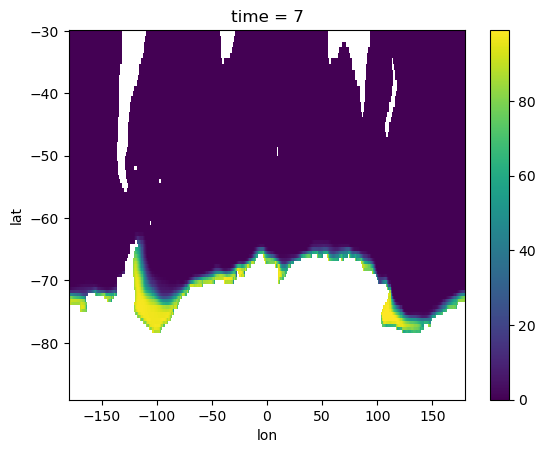

In [135]:
cmip_ds['MIROC-ESL2'].isel(time = 6).plot()

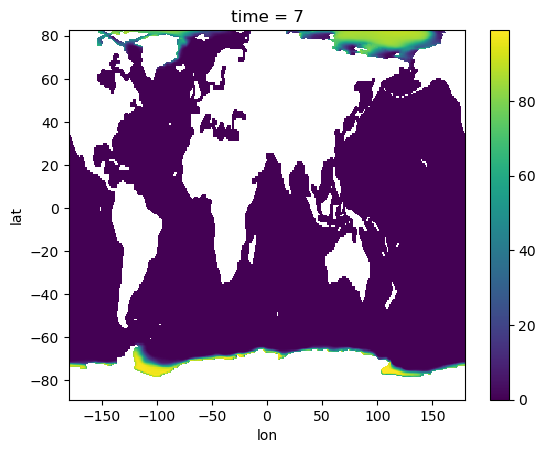

In [136]:
# ds_mat = loadmat(cmip_files[7])
# #Getting longitude
# lon = ds_mat['Lon'][0]
# #Changing longitude range to +/-180
# lon = ((lon+180)%360)-180
# #Getting longitude and latitude
# lat = ds_mat['Lat'][:,0]
# #Creating data array
# sic_ds = xr.DataArray(data = ds_mat['siconc'],
#                       dims = ['time', 'lat', 'lon'],
#                       coords = {'lat': lat, 'lon': lon, 
#                                 #Monthly data
#                                 'time': range(1, 13)})
# sic_ds = sic_ds.sortby(sic_ds.lon)
sic_ds.isel(time = 6).plot()
# ds_mat['siconc'].shape
# ds_mat['Lon'].shape
#Check 3:7
#Check MIROC-ESL2

In [117]:
cmip_ds.keys()

dict_keys(['CESM2', 'CanESM5-CMOC', 'IPSL-CM6A-LR', 'MIROC-ESL2', 'CanESM5-CanOE', 'UKESM1-0-LL', 'ACCESS-ESM-1-5'])

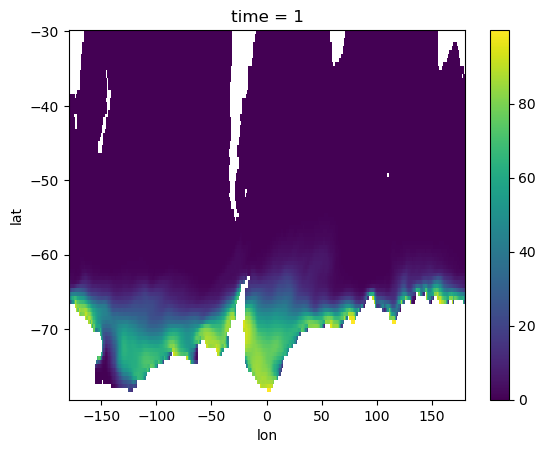

In [37]:
# 
# ds_mat = loadmat(cmip_files[0])
# lon = ds_mat['Lon'][0]
# lon = ((lon + 180)%360)-180
# lat = ds_mat['Lat'][:,0]
sic_ds = xr.DataArray(data = ds_mat['siconc'],
             dims = ['time', 'lat', 'lon'],
             coords = {'lat': lat, 'lon': lon, 'time': range(1, 13)})
sic_ds = sic_ds.sortby(sic_ds.lon)
sic_ds = xr.where(sic_ds >= 1e20, np.nan, sic_ds).sel(lat = slice(-90, -30))
sic_ds.isel(time = 0).plot()

In [38]:
sic_ds.max()

<xarray.DataArray ()> Size: 8B
array(99.99956865)

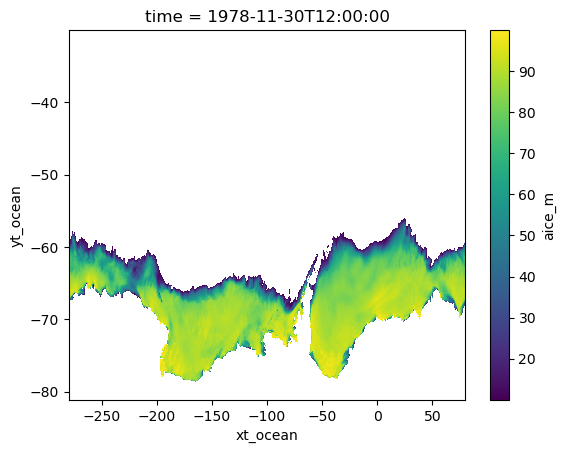

In [8]:
#Start cookbook session
session = cc.database.create_session()

#Load ACCESS data
access_sic = cc.querying.getvar(expt = '01deg_jra55v140_iaf_cycle4', variable = 'aice_m', session = session, 
                                frequency = '1 monthly', start_time = '1978', end_time = '2011', 
                                decode_coords = False)

#Accessing corrected coordinate data to update geographical coordinates in the array of interest
area_t = cc.querying.getvar('01deg_jra55v140_iaf_cycle4', 'area_t', session, n = 1)
#Apply time correction so data appears in the middle (12:00) rather than at the beginning of the day (00:00)
access_sic['time'] = access_sic.time.to_pandas() - dt.timedelta(hours = 12)
#Change coordinates so they match ocean dimensions 
access_sic.coords['ni'] = area_t['xt_ocean'].values
access_sic.coords['nj'] = area_t['yt_ocean'].values
#Rename coordinate variables so they match ocean data
access_sic = access_sic.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))

#Select area and period of interest
access_sic = access_sic.sel(yt_ocean = slice(-90, -30), time = slice('1978-11', '2010-12'))*100
#Apply 10% SIC threshold to match observations
access_sic = xr.where(access_sic < 10, np.nan, access_sic)
#Check results for first time step
access_sic.isel(time = 0).plot()

## Calculating seasonal climatologies

In [9]:
access_clim = access_sic.groupby('time.season').mean()

## Plotting climatologies from observations and Earth System Models

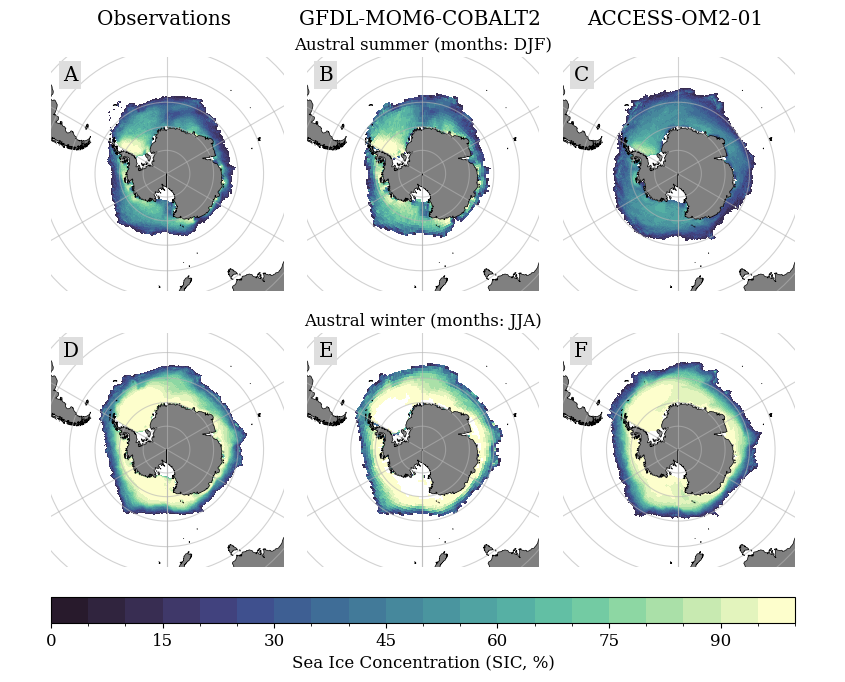

In [53]:
#Initialise figure - change width and height (6.4, 4.8)
fig = plt.figure(figsize = [9.6, 7.5], constrained_layout = True)

#Setting levels for colorbar
levels = np.arange(0, 101, 5)

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

#Define projection to polar
projection = ccrs.SouthPolarStereo()

#Create variable containing the Antarctic continent - 50m is medium scale
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black',
                                   facecolor = 'gray', linewidth = 0.5)

#Defining datasets to be plotted
data = ['Observations',
        'GFDL-MOM6-COBALT2', 
        'ACCESS-OM2-01']

#Defining season names
seasonName = {'DJF': 'Austral summer (months: DJF)',  
              'JJA': 'Austral winter (months: JJA)'}

#Merge seasons and dasets to create a counter
counter = zip(cycle(data), np.repeat(list(seasonName), len(data)))

#Create composite figure using a grid (3 rows for each season and a colourbar,
#and 3 columns for each dataset)
gs = gridspec.GridSpec(nrows = len(seasonName)+1, ncols = len(data), 
                       height_ratios = (1, 1, 0.1), wspace = 0.1, hspace = 0.1)

#Initialise empty list for axes containing subplots
ax = {}

#Looping through counter to create plots
for i, coord in enumerate(counter):
    ax[i] = fig.add_subplot(gs[i], projection = ccrs.SouthPolarStereo())
    #Observations
    if coord[0] == 'Observations':
        da = nsidc_clim.sel(season = coord[1])
        p1 = da.plot.pcolormesh(x = 'xgrid', y = 'ygrid', ax = ax[i], add_colorbar = False,
                                cmap = cm.cm.deep_r, levels = levels)
    else:
        if 'GFDL' in coord[0]:
            da_m = gfdl_clim.sel(season = coord[1])
        else:
            da_m = access_clim.sel(season = coord[1])
        p2 = da_m.plot.pcolormesh(ax = ax[i], add_colorbar = False, cmap = cm.cm.deep_r, 
                                  levels = levels, transform = ccrs.PlateCarree())
    #Set title for maps
    if i < 3:
        ax[i].set_title(f'{coord[0]} \n', y = 1.01)
    else:
        ax[i].set_title('', y = 1.01)

    #Add subtitle for seasons
    if i in [1, 4]:
        ax[i].text(0.5, 1.05, f'{seasonName[coord[1]]}', horizontalalignment = 'center',
                   verticalalignment = 'center', transform = ax[i].transAxes)
    
    #Add land
    ax[i].add_feature(land_50m)
    #Set extent of map
    ax[i].set_extent([-180, 180, -90, -42.5], crs = ccrs.PlateCarree())
    #Draw gridlines
    gl = ax[i].gridlines(draw_labels = True, y_inline = False, color = '#b4b4b4',
                         alpha = 0.6)
    #Removing coordinate labels for latitude and longitude
    gl.xlabel_style = {'alpha': 0}
    gl.ylabel_style = {'alpha': 0}
    #Remove outer frame
    [s.set_visible(False) for s in ax[i].spines.values()]
    [t.set_visible(False) for t in ax[i].get_xticklines()]
    [t.set_visible(False) for t in ax[i].get_yticklines()]

#Add colourbar
ax_col = fig.add_subplot(gs[-1, 0:])
cb = plt.colorbar(p1, cax = ax_col, orientation = 'horizontal', shrink = 0.8,
                  fraction = 0.2, label = 'Sea Ice Concentration (SIC, %)')

#Labelling plots - Getting the alphabet in upper case
labels = string.ascii_uppercase[0:6]
#Apply labels only to plots, not colorbars
for a in ax:
    if a < 6:
        ax[a].text(0.05, .9, labels[a], transform = ax[a].transAxes, 
                   fontsize = 'large',
                   bbox = dict(facecolor = '#dedede', edgecolor = 'none',
                               pad = 3.0))

#Save figure
plt.savefig('outputs/SIC_comp_obs_ESMs.png', dpi = 300, bbox_inches = 'tight',
           pad_inches = 0.05)

## Calculating sea ice extent
Sea ice extent was calculated following [Hobbs et al 2016](10.1016/j.gloplacha.2016.06.008). They added the area of all ocean grid cells that had a sea ice concentration of 15\% or higher.

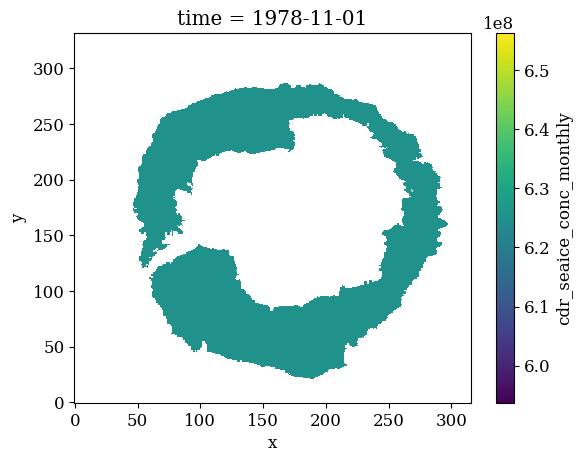

In [56]:
# Observations - Identify areas with SIC >= 15% and replace with area of pixel (25,000 m2)
nsidc_sie = xr.where(nsidc_ds >= 0.15, (25000**2), np.nan)
nsidc_sie.isel(time = 0).plot()

In [87]:
gfdl_area = xr.open_dataset('data/gfdl-mom6-cobalt2_obsclim_areacell0_60arcmin_global_fixed.nc')
gfdl_area = gfdl_area.sel(lat = slice(-30, -90))
# gfdl_sie = xr.where(gfdl_sic >= 15, gfdl_area, np.nan)
gfdl_area.lon.values

array([-179.5, -178.5, -177.5, -176.5, -175.5, -174.5, -173.5, -172.5,
       -171.5, -170.5, -169.5, -168.5, -167.5, -166.5, -165.5, -164.5,
       -163.5, -162.5, -161.5, -160.5, -159.5, -158.5, -157.5, -156.5,
       -155.5, -154.5, -153.5, -152.5, -151.5, -150.5, -149.5, -148.5,
       -147.5, -146.5, -145.5, -144.5, -143.5, -142.5, -141.5, -140.5,
       -139.5, -138.5, -137.5, -136.5, -135.5, -134.5, -133.5, -132.5,
       -131.5, -130.5, -129.5, -128.5, -127.5, -126.5, -125.5, -124.5,
       -123.5, -122.5, -121.5, -120.5, -119.5, -118.5, -117.5, -116.5,
       -115.5, -114.5, -113.5, -112.5, -111.5, -110.5, -109.5, -108.5,
       -107.5, -106.5, -105.5, -104.5, -103.5, -102.5, -101.5, -100.5,
        -99.5,  -98.5,  -97.5,  -96.5,  -95.5,  -94.5,  -93.5,  -92.5,
        -91.5,  -90.5,  -89.5,  -88.5,  -87.5,  -86.5,  -85.5,  -84.5,
        -83.5,  -82.5,  -81.5,  -80.5,  -79.5,  -78.5,  -77.5,  -76.5,
        -75.5,  -74.5,  -73.5,  -72.5,  -71.5,  -70.5,  -69.5,  -68.5,
      

In [75]:
gfdl_sic.lon.values[gfdl_sic.lon.values != gfdl_area.lon.values]

array([-163.5, -154.5, -145.5, -136.5, -130.5, -126.5, -125.5, -122.5,
       -121.5, -117.5, -116.5, -113.5, -112.5, -108.5, -107.5, -104.5,
        -99.5,  -90.5,  -81.5,  -72.5,  -63.5,  -54.5,  -45.5,  -36.5,
        -27.5,  -18.5,   -9.5,   -0.5,    1.5,    7.5,   14.5,   28.5,
         29.5,   52.5,   61.5,   62.5,   63.5,  100.5,  109.5,  115.5,
        118.5,  120.5,  122.5,  124.5,  127.5])

In [84]:
gfdl_sic.lon.values[16]

-163.5

In [85]:
gfdl_area.lon.values[16]

-163.49999999999997

In [23]:
base_path = '/g/data/jk72/la6889/FishMIP/SOMEME/'
env_data = pd.read_csv(os.path.join(base_path, 'data/lme_esm_observed_npp_sst.csv'))
#Keep SO data
env_data = env_data[env_data.lat <= -30]

In [26]:
x = env_data.pivot(index = 'lat', columns = 'lon', values = 'observed_tos_C')
x

lon,-179.5,-178.5,-177.5,-176.5,-175.5,-174.5,-173.5,-172.5,-171.5,-170.5,...,170.5,171.5,172.5,173.5,174.5,175.5,176.5,177.5,178.5,179.5
lat,,,,,,,,,,,,,,,,,,,,,
-89.5,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,...,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001
-88.5,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,...,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001
-87.5,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,...,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001
-86.5,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,...,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001
-85.5,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,...,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001
-84.5,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,...,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001
-83.5,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,...,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001
-82.5,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,...,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001
-81.5,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,...,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001,-1.790001


In [33]:
env_data_da = xr.DataArray(data = x.values,
                           dims = ['lat', 'lon'],
                           coords = {'lat': x.index.values,
                                     'lon': x.columns.values})

Text(0.5, 1.0, 'NA values from TOS')

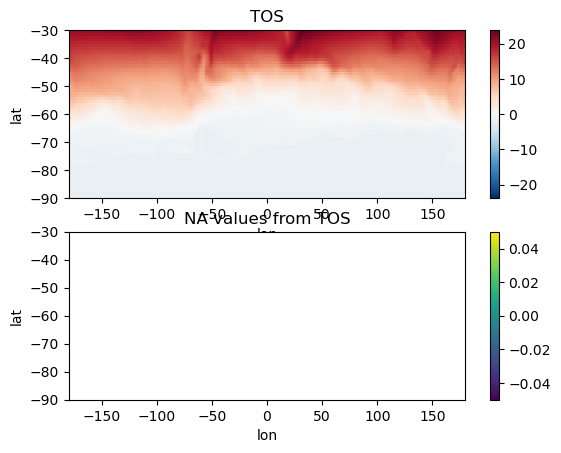

In [61]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
env_data_da.plot(ax = ax1)
ax1.set_title('TOS')
ax2 = fig.add_subplot(212)
xr.where(np.isnan(env_data_da), 1, np.nan).plot(ax =ax2)
ax2.set_title('NA values from TOS')

In [49]:
env_data.describe()

,lat,lon,area_m2,lme_all,observed_intpp_gC_m2_yr,observed_tos_C
count,21600.000000,21600.000000,2.160000e+04,2160.000000,13877.000000,21600.000000
mean,-60.000000,0.000000,5.888701e+09,50.494444,109.856287,4.655185
std,17.318503,103.925053,3.147492e+09,16.548355,51.035134,7.527563
min,-89.500000,-179.500000,1.077756e+08,13.000000,6.431513,-1.790001
25%,-74.750000,-89.750000,3.247676e+09,43.000000,76.685675,-1.790001
50%,-60.000000,0.000000,6.169754e+09,61.000000,97.706345,0.551708
75%,-45.250000,89.750000,8.680138e+09,61.000000,130.122401,10.712958
max,-30.500000,179.500000,1.061499e+10,61.000000,1000.000000,23.854973


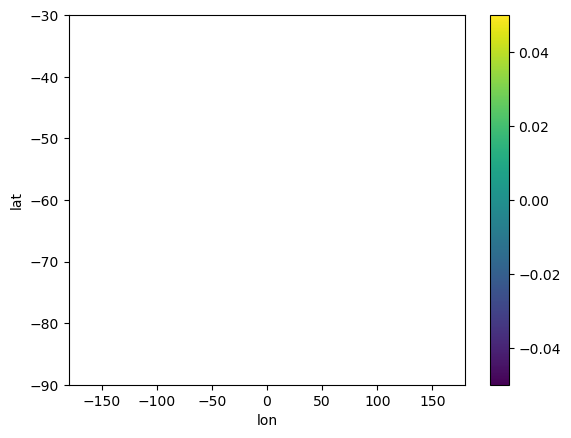

In [38]:
env_data_da.where(np.isnan(env_data_da)).plot()

In [39]:
env_data

,lat,lon,area_m2,lme_all,observed_intpp_gC_m2_yr,observed_tos_C
120,-30.5,-179.5,1.061499e+10,NaN,150.228757,20.645889
121,-31.5,-179.5,1.050479e+10,NaN,152.959082,20.014665
122,-32.5,-179.5,1.039138e+10,NaN,154.614307,19.362945
123,-33.5,-179.5,1.027481e+10,NaN,155.197572,18.833083
124,-34.5,-179.5,1.015511e+10,NaN,154.894682,18.405694
...,...,...,...,...,...,...
64795,-85.5,179.5,9.689762e+08,NaN,NaN,-1.790001
64796,-86.5,179.5,7.539606e+08,NaN,NaN,-1.790001
64797,-87.5,179.5,5.387107e+08,NaN,NaN,-1.790001
64798,-88.5,179.5,3.232934e+08,NaN,NaN,-1.790001


In [50]:
y = env_data.pivot(index = 'lat', columns = 'lon', values = 'observed_intpp_gC_m2_yr')
y_da = xr.DataArray(data = y.values,
                    dims = ['lat', 'lon'],
                   coords = {'lat': y.index.values,
                             'lon': y.columns.values})

Text(0.5, 1.0, 'NA values from INTPP')

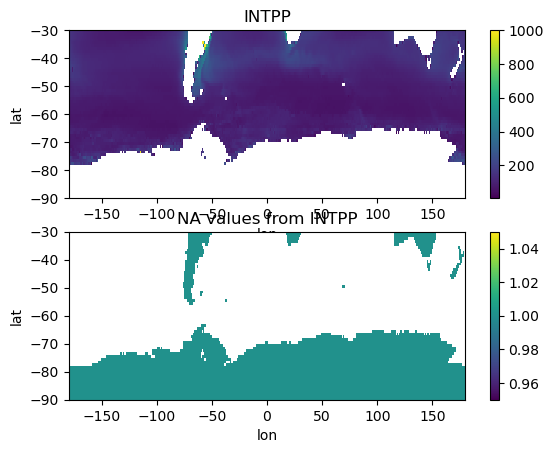

In [63]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
y_da.plot(ax = ax1)
ax1.set_title('INTPP')
ax2 = fig.add_subplot(212)
xr.where(np.isnan(y_da), 1, np.nan).plot(ax =ax2)
ax2.set_title('NA values from INTPP')

In [13]:
sic_ds.var

<bound method DatasetAggregations.var of <xarray.Dataset> Size: 1GB
Dimensions:                           (tdim: 530, y: 332, x: 316)
Coordinates:
    time                              (tdim) datetime64[ns] 4kB 1978-11-01 .....
    xgrid                             (x) float32 1kB ...
    ygrid                             (y) float32 1kB ...
Dimensions without coordinates: tdim, y, x
Data variables:
    cdr_seaice_conc_monthly           (tdim, y, x) float32 222MB ...
    nsidc_bt_seaice_conc_monthly      (tdim, y, x) float32 222MB ...
    nsidc_nt_seaice_conc_monthly      (tdim, y, x) float32 222MB ...
    projection                        |S1 1B ...
    qa_of_cdr_seaice_conc_monthly     (tdim, y, x) float32 222MB ...
    stdev_of_cdr_seaice_conc_monthly  (tdim, y, x) float32 222MB ...
    latitude                          (y, x) float32 420kB ...
    longitude                         (y, x) float32 420kB ...
Attributes: (12/40)
    Conventions:               CF-1.6, ACDD-1.3
    title